### Period finder
Given a long lightcurve, single band or multiband, we can explore if there is a periodic component.
Uses the Conditional Entopy method of [Graham++](https://academic.oup.com/mnras/article/434/3/2629/1044188).
Numpy implementation influenced by [Lauffer](https://github.com/glauffer/Conditional-Entropy/blob/master/conditional_entropy.py)

In [1]:
import math, random, sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# First make a sine wave with noise as a trial lightcurve
def fake_lightcurve(npoints, period, noise):
    data = []
    it = 0
    for i in range(npoints):
        it += random.randrange(2,6)
        t = it + random.random()/3
        y = math.sin(2*3.14158*t/period) + noise*random.random()
        data.append([t, y])
    return np.array(data)

In [3]:
# divide the time of observations by the period
def get_phase(time, period, shift=0.0):
    return (time / period - shift) % 1

#  Here we transform the time of observations to the phase space
def rephase(data, period, shift=0.0, col=0, copy=True):
    rephased = np.ma.array(data, copy=copy)
    rephased[:, col] = get_phase(rephased[:, col], period, shift)
    return rephased

# Normalize the lightcurve between 0 and 1
def normalization(data):
    norm = np.ma.copy(data)
    norm[:,1] = (norm[:,1] - np.min(norm[:,1])) \
        / (np.max(norm[:,1]) - np.min(norm[:,1]))

    return norm

### Evaluate conditional entropy for given period

In [4]:
def cond_entropy(period, data, p_bins=10, m_bins=5):
    if period <= 0:
        return np.PINF
    ndata = normalization(data)
    r = rephase(ndata, period)
    bins, *_ = np.histogram2d(r[:,0], r[:,1], [p_bins, m_bins],
                                [[0,1], [0,1]])
    size = r.shape[0]
    if size > 0:
        divided_bins = bins / size
        arg_positive = divided_bins > 0
        column_sums = np.sum(divided_bins, axis=1) #change 0 by 1
        column_sums = np.repeat(np.reshape(column_sums,(p_bins,1)), m_bins, axis=1)

        select_divided_bins = divided_bins[arg_positive]
        select_column_sums  = column_sums[arg_positive]

        A = np.empty((p_bins, m_bins), dtype=float)
        A[ arg_positive] = select_divided_bins \
                         * np.log(select_column_sums / select_divided_bins)
        A[~arg_positive] = 0
        return np.sum(A)
    else:
        return np.PINF

### Now we do a test run
The period is 250 days, with 10% noise on the sine wave

In [5]:
npoints      = 1000
real_period  = 250  # days
noise        = 0.1 # compared to amplitude
data = fake_lightcurve(npoints, real_period, noise)

#### Plot the fake lightcurve

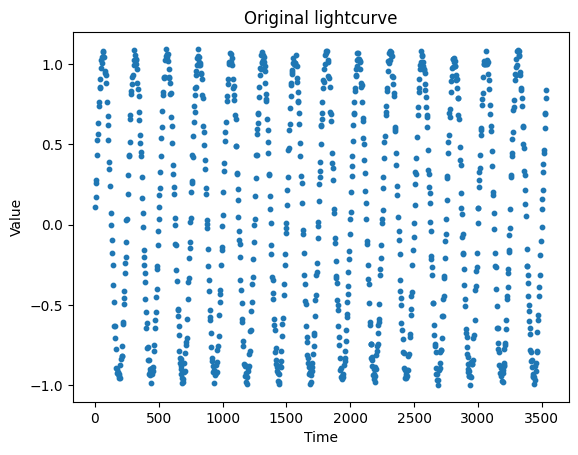

In [6]:
plt.scatter(data[:,0], data[:,1], s=10)
plt.title('Original lightcurve')
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

Here we look at the folded lightcurve when we are very close to the correct period. 
First as a scatter plot, then as a 2D histogram from which the CE is computed.

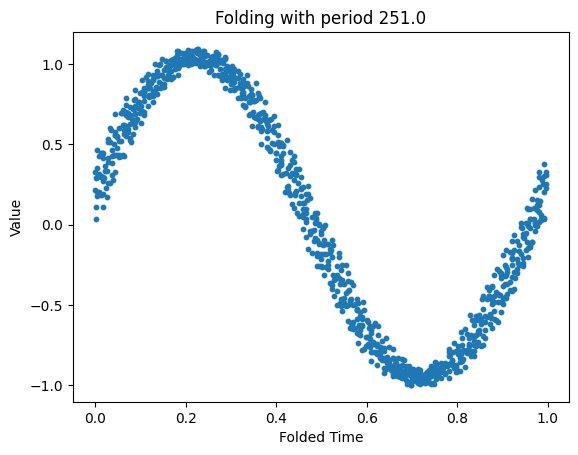

In [7]:
def plotfold(data, period):
    rdata = rephase(data, period)
    plt.scatter(rdata[:,0], rdata[:,1], s=10)
    plt.title('Folding with period %.1f' % period)
    plt.xlabel("Folded Time")
    plt.ylabel("Value")
    plt.show()

period = 251
plotfold(data, period)

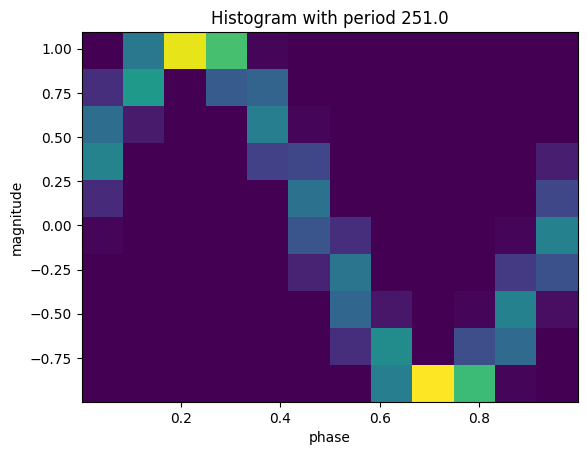

In [8]:
def plothist(data, period, p_bins=10, m_bins=5):
    rdata = rephase(data, period)
    ndata = normalization(rdata)
    plt.hist2d(rdata[:, 0], rdata[:, 1], bins=(p_bins,m_bins))
    plt.title('Histogram with period %.1f' % period)
    plt.xlabel('phase')
    plt.ylabel('magnitude')
    plt.show()

p_bins=12
m_bins=10
plothist(data, period, p_bins, m_bins)

From this histogram with $m_i$ bins in magnitude and $p_i$ bins in phase, 
the conditional entropy is $$ H_c = \sum_{i, j} {p(m_i, \phi_j) \ln \frac {p(\phi_j)}{p(m_i, \phi_j)}}$$

#### Minimise the CE to get the period

In [9]:
# A range of periods to try, from 200 to 600 days
min_period = 50
max_period = 450
n_period   = 400
periods = []
for i in range(n_period):
    periods.append(min_period + i*(max_period-min_period)/n_period)

In [10]:
# Now compute the CE for each period
ce = []
for period in periods:
    ce_value = cond_entropy(period, data, p_bins=p_bins, m_bins=m_bins)
    ce.append(ce_value)
    imin = np.argmin(ce)
period = periods[imin]
min_entropy = ce[imin]

imax= np.argmax(ce)
max_entropy = ce[imax]
rat = min_entropy/max_entropy
if rat < 0.6:
    print('Entropy ratio for period %.2f is %.3f' % (period, rat))

Entropy ratio for period 250.00 is 0.294


#### Plot CE as a function of period

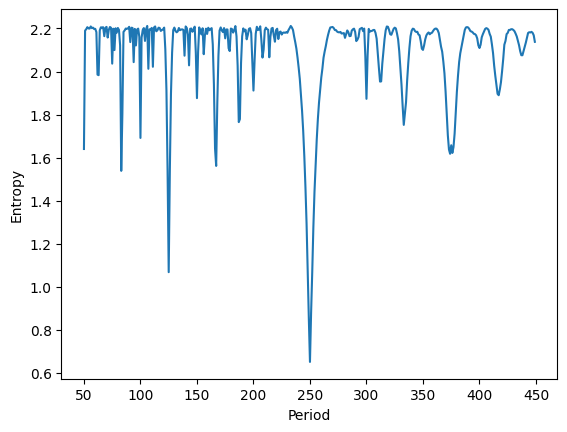

In [11]:
plt.plot(periods, ce)
plt.xlabel("Period")
plt.ylabel("Entropy")
plt.show()